# Single-Pass Encoding with scGPT TransformerModel

This notebook demonstrates how to:
1. Load the pre-trained scGPT model and Immune Human dataset (from Tutorial_GRN)
2. Tokenize and pad the data
3. Create a PyTorch DataLoader
4. Run `model._encode` to get transformer output embeddings

## Load pre-trained model and dataset

In [1]:
import json
import os
from pathlib import Path
import sys
import warnings

import torch
import numpy as np
import scanpy as sc
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, "../")
from scgpt.tokenizer.gene_tokenizer import GeneVocab, tokenize_and_pad_batch
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

/home/chasty2/Documents/scFM_benchmarking/.venv/lib/python3.12/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/chasty2/Documents/scFM_benchmarking/.venv/lib/python3.12/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/chasty2/Documents/scFM_benchmarking/.venv/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/chasty2/Documents/scFM_benchmarking/.venv/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHT

In [2]:
set_seed(42)

pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

### Load pre-trained model

In [3]:
model_dir = Path("../models/scGPT_bc")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

with open(model_config_file, "r") as f:
    model_configs = json.load(f)

embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file, map_location=device))
    print(f"Loading all model params from {model_file}")
except Exception:
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file, map_location=device)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

model.to(device)
model.eval()
print(f"Model on {device}")

Loading params encoder.embedding.weight with shape torch.Size([36574, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

### Load and preprocess dataset

In [5]:
data_dir = Path("../data")
adata = sc.read(str(data_dir / "Immune_ALL_human.h5ad"), cache=True)
adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)
data_is_raw = False

preprocessor = Preprocessor(
    use_key="X",
    filter_gene_by_counts=3,
    filter_cell_by_counts=False,
    normalize_total=1e4,
    result_normed_key="X_normed",
    log1p=data_is_raw,
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,
    hvg_flavor="cell_ranger",
    binning=n_bins,
    result_binned_key="X_binned",
)
preprocessor(adata, batch_key="batch")
print(f"adata shape after preprocessing: {adata.shape}")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...
adata shape after preprocessing: (33506, 1200)


## Tokenize and pad the data

`tokenize_and_pad_batch` converts the binned expression matrix into:
- **"genes"**: gene token IDs, shape `(n_cells, max_len)`
- **"values"**: expression values, shape `(n_cells, max_len)`

It appends a `<cls>` token at position 0 and pads shorter sequences.

In [6]:
# Map gene names in adata to their vocab indices
genes_in_vocab = [g for g in adata.var.index if g in gene2idx]
gene_ids = np.array([gene2idx[g] for g in genes_in_vocab])

# Get the binned expression matrix for genes in vocab
gene_mask = adata.var.index.isin(genes_in_vocab)
counts = adata.layers["X_binned"][:, gene_mask]
if hasattr(counts, "toarray"):
    counts = counts.toarray()
counts = counts.astype(np.float32)

print(f"Genes in vocab: {len(genes_in_vocab)} / {adata.n_vars}")
print(f"Expression matrix shape: {counts.shape}")

Genes in vocab: 1173 / 1200
Expression matrix shape: (33506, 1173)


In [7]:
max_seq_len = len(genes_in_vocab) + 1  # +1 for <cls> token

tokenized_data = tokenize_and_pad_batch(
    counts,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)

print(f"Tokenized keys: {list(tokenized_data.keys())}")
print(f"gene_ids shape: {tokenized_data['genes'].shape}")
print(f"values shape:   {tokenized_data['values'].shape}")

Tokenized keys: ['genes', 'values']
gene_ids shape: torch.Size([33506, 1174])
values shape:   torch.Size([33506, 1174])


## Create a DataLoader

In [8]:
class SeqDataset(Dataset):
    def __init__(self, data: dict):
        self.data = data

    def __len__(self):
        return self.data["genes"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# The full dataset needs ~100GB RAM
tokenized_subset = {key: value[:10000] for key,value in tokenized_data.items()}
dataset = SeqDataset(tokenized_subset)
print(f"Dataset size: {len(dataset)} cells")

Dataset size: 10000 cells


In [9]:
batch_size = 64

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=4,
    pin_memory=True,
)

print(f"Number of batches: {len(dataloader)}")

Number of batches: 157


## Test `model._encode`

`_encode` takes:
- `src`: gene token IDs `(batch, seq_len)` - long tensor
- `values`: expression values `(batch, seq_len)` - float tensor
- `src_key_padding_mask`: boolean mask `(batch, seq_len)` - `True` where padded

Returns: transformer output `(batch, seq_len, embsize)`

In [10]:
# Grab a single batch to demonstrate
batch = next(iter(dataloader))
src = batch["genes"].to(device)          # (batch_size, seq_len)
values = batch["values"].to(device)      # (batch_size, seq_len)

# Padding mask: True where the value equals pad_value
src_key_padding_mask = src.eq(vocab[pad_token]).to(device)

print(f"src shape:              {src.shape}")
print(f"values shape:           {values.shape}")
print(f"padding_mask shape:     {src_key_padding_mask.shape}")
print(f"padding_mask % True:    {src_key_padding_mask.float().mean():.2%}")

src shape:              torch.Size([64, 1174])
values shape:           torch.Size([64, 1174])
padding_mask shape:     torch.Size([64, 1174])
padding_mask % True:    0.00%


In [11]:
with torch.no_grad():
    output = model._encode(
        src=src,
        values=values,
        src_key_padding_mask=src_key_padding_mask,
    )

print(f"Encoder output shape: {output.shape}")  # (batch_size, seq_len, embsize)

Encoder output shape: torch.Size([64, 1174, 512])


In [12]:
# The CLS token embedding (position 0) is the cell-level representation
cls_embeddings = output[:, 0, :]  # (batch_size, embsize)
print(f"CLS embeddings shape: {cls_embeddings.shape}")

# Gene-level embeddings are at positions 1 onwards
gene_embeddings = output[:, 1:, :]  # (batch_size, n_genes, embsize)
print(f"Gene embeddings shape: {gene_embeddings.shape}")

CLS embeddings shape: torch.Size([64, 512])
Gene embeddings shape: torch.Size([64, 1173, 512])


## Encode the Dataset

Loop over all batches in the DataLoader to collect embeddings for every cell.

In [ ]:
all_cls_embeddings = []
cell_dep_gene_embeddings = []

with torch.no_grad():
    for batch in dataloader:
        src = batch["genes"].to(device)
        values = batch["values"].to(device)
        src_key_padding_mask = src.eq(vocab[pad_token]).to(device)

        output = model._encode(
            src=src,
            values=values,
            src_key_padding_mask=src_key_padding_mask,
        )

        # Collect CLS token embeddings
        all_cls_embeddings.append(output[:, 0, :].cpu())

        # Collect gene embeddings for each cell
        cell_dep_gene_embeddings.append(output[:, 1:, :].cpu())

all_cls_embeddings = torch.cat(all_cls_embeddings, dim=0).numpy()
cell_dep_gene_embeddings = torch.cat(cell_dep_gene_embeddings, dim=0).numpy()
print(f"CLS embeddings: {all_cls_embeddings.shape}")
print(f"Cell-dependent gene embeddings: {cell_dep_gene_embeddings.shape}")

Full dataset CLS embeddings: (10000, 512)
Cell-dependent gene embeddings: (10000, 1173, 512)


## Create UMAP of CLS embeddings

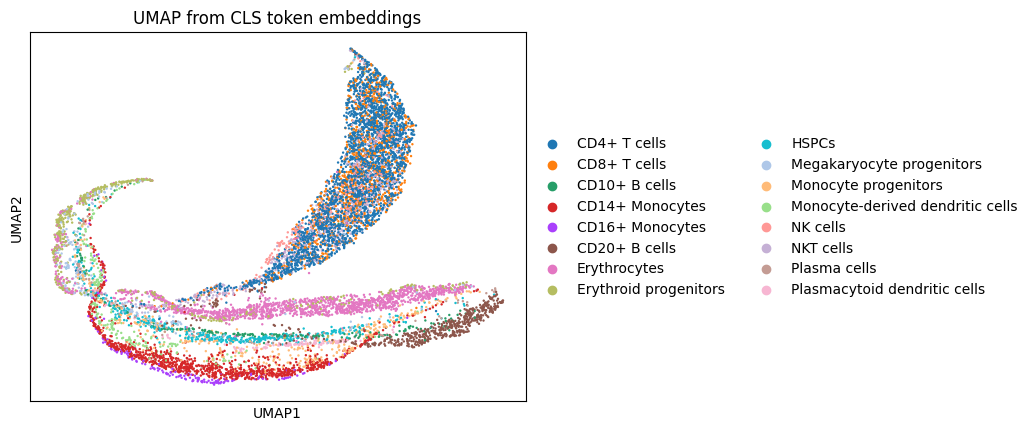

In [19]:
# Create AnnData
cls_embed_adata = sc.AnnData(X=all_cls_embeddings)
cls_embed_adata.obs["celltype"] = adata.obs["celltype"].values[:len(cls_embed_adata)]
cls_embed_adata.obs["cell_id"] = adata.obs.index[:len(cls_embed_adata)]

# Calculate umap
sc.pp.neighbors(cls_embed_adata, use_rep="X")
sc.tl.umap(cls_embed_adata)
sc.pl.umap(cls_embed_adata, color="celltype", title="UMAP from CLS token embeddings")

In [20]:
import plotly.express as px
import pandas as pd

cls_umap_df = pd.DataFrame(
    cls_embed_adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"]
)
cls_umap_df["celltype"] = cls_embed_adata.obs["celltype"].values
cls_umap_df["cell_id"] = cls_embed_adata.obs["cell_id"].values

fig = px.scatter(
    cls_umap_df, x="UMAP1", y="UMAP2", color="celltype",
    hover_name="cell_id",
    title="UMAP from CLS token embeddings",
    width=900, height=700,
)
fig.update_traces(marker_size=2)
fig.show()

## Create UMAP of Single-cell Gene Embeddings

In [ ]:
# UMAP of gene embeddings for a single cell (cell 0)
single_cell_gene_embs = cell_dep_gene_embeddings[0]  # (1173, 512)
cell_id = adata.obs.index[0]
gene_adata = sc.AnnData(X=single_cell_gene_embs)
gene_adata.obs["gene"] = genes_in_vocab

sc.pp.neighbors(gene_adata, use_rep="X")
sc.tl.umap(gene_adata)

gene_umap_df = pd.DataFrame(
    gene_adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"]
)
gene_umap_df["gene"] = gene_adata.obs["gene"].values


fig = px.scatter(
    gene_umap_df, x="UMAP1", y="UMAP2",
    hover_name="gene",
    title=f"UMAP of single-cell gene embeddings (cell: {cell_id})",
    width=900, height=700,
)
fig.update_traces(marker_size=4)
fig.show()